In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns 
import missingno as msn
import tqdm
import time

from wordcloud import WordCloud

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import dump_svmlight_file
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split


import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC #(setting multi_class=”crammer_singer”)
from sklearn.linear_model import LogisticRegression, RidgeClassifier #(LogReg: setting multi_class = "multinomial")
from sklearn.ensemble import RandomForestClassifier

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data Fields - from the competitions description
<ul><li><p>PetID - Unique hash ID of pet profile</p></li>
    <li><p>AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.</p></li>
    <li><p>Type - Type of animal (1 = Dog, 2 = Cat)</p></li>
    <li><p>Name - Name of pet (Empty if not named)</p></li>
    <li><p>Age - Age of pet when listed, in months</p></li>
    <li><p>Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)</p></li>
    <li><p>Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)</p></li>
    <li><p>Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)</p></li>
    <li><p>Color1 - Color 1 of pet (Refer to ColorLabels dictionary)</p></li>
    <li><p>Color2 - Color 2 of pet (Refer to ColorLabels dictionary)</p></li>
    <li><p>Color3 - Color 3 of pet (Refer to ColorLabels dictionary)</p></li>
    <li><p>MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)</p></li>
    <li><p>FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)</p></li>
    <li><p>Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)</p></li>
    <li><p>Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)</p></li>
    <li><p>Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)</p></li>
    <li><p>Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)</p></li>
    <li><p>Quantity - Number of pets represented in profile</p></li>
    <li><p>Fee - Adoption fee (0 = Free)</p></li>
    <li><p>State - State location in Malaysia (Refer to StateLabels dictionary)</p></li>
    <li><p>RescuerID - Unique hash ID of rescuer</p></li>
    <li><p>VideoAmt - Total uploaded videos for this pet</p></li>
    <li><p>PhotoAmt - Total uploaded photos for this pet</p></li>
    <li><p>Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.</p></li></ul>
   
 
## Adoption speed
### Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:   
   <li><p>0 - Pet was adopted on the same day as it was listed.</p></li>
    <li><p>1 - Pet was adopted between 1 and 7 days (1st week) after being listed.</p></li>
    <li><p>2 - Pet was adopted between 8 and 30 days (1st month) after being listed.</p></li>
    <li><p>3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.</p></li>
    <li><p>4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). </p></li>
    
     
    








### Data import 

In [4]:
train = pd.read_csv("../input/train/train.csv", index_col="PetID")
test = pd.read_csv("../input/test/test.csv", index_col="PetID")

### Data inspection

In [ ]:
display(train.columns)
display(test.columns)

In [5]:
train["IsTraining"] = 1
test["IsTraining"]  = 0

merged = pd.concat([train,test])

cat = ["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize",
      "FurLength", "Vaccinated", "Dewormed", "Sterilized"]

for c in cat:
    merged[c] = merged[c].astype("category")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [ ]:
merged.dtypes

In [ ]:
merged.describe(include='all')

In [ ]:
merged.sample(5)

In [ ]:
msn.matrix(merged, sort='ascending')

### Data looks very complete. Some animals do not have a name and the description is not available in one case. 

# EDA

In [ ]:
def percConvert(ser):
    return ser/float(ser[-1])

In [ ]:
train.dtypes

# Type
### This shows wether the animal is a dog (1) or a cat (2) 

In [ ]:
type_ct = pd.crosstab(train["Type"],train["AdoptionSpeed"],margins=True).apply(percConvert, axis=1)
display(type_ct)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
sns.countplot("Type", data=train, ax=ax[0])
ax[0].set_xticklabels(["Dog", "Cat"])
ax[0].set_title("Dogs Vs Cats")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

sns.countplot("Type", hue="AdoptionSpeed", data=train, ax=ax[1])
ax[1].set_title("AdoptionSpeed by Type")
ax[1].set_xticklabels(["Dog", "Cat"])
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

### The following function for the generation of count plots is derived from this very nice kernel <hl>https://www.kaggle.com/artgor/exploration-of-data-step-by-step</hl>

In [ ]:
main_count = train["AdoptionSpeed"].value_counts(normalize=True).sort_index()

def prepare_plot_dict(df, col, main_count):
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(i for i in val_count.values())) / 
                                           main_count[k]) * 100 - 100
                
            else:
                plot_dict[0] = 0
                
    return plot_dict
                
def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count, super_ax=0):
    if super_ax != 0:
        g = sns.countplot(x=x, data=df, hue=hue, ax=super_ax);
        super_ax.set_title(title);
    else:
        g = sns.countplot(x=x, data=df, hue=hue)
        plt.title("AdoptionSpeed {}".format(title));
    ax = g.axes
    
    plot_dict = prepare_plot_dict(df, x, main_count)
    
    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0 
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x()+p.get_width()/2., h), ha='center', va='center', 
                    fontsize=11, color="green" if plot_dict[h] > 0 else "red", 
                    rotation=0, xytext=(0,10), textcoords="offset points")

In [ ]:
plt.figure(figsize=(18,8))
make_count_plot(df=train, x='Type', title='by pet Type')

In [ ]:
dict(train.loc[train['Type']== 1, 'AdoptionSpeed'].value_counts().sort_index())

In [ ]:
plt.figure()
ax = plt.subplot()
plt.bar(range(5),type_ct.iloc[0,:-1],alpha=.5,color="green",label="Dog")
plt.bar(range(5),type_ct.iloc[1,:-1],alpha=.5,color="purple",label="Cat")
for idx,i in enumerate(type_ct.iloc[2,:-1]):
    if idx==0:
        plt.hlines(y=i,xmin=idx-.5, xmax=idx+.5, color="red", linestyle="dashed", label="MeanPerc")
    else:
        plt.hlines(y=i,xmin=idx-.5, xmax=idx+.5, color="red", linestyle="dashed")
        
plt.legend()
plt.title("% AdoptionSpeed by Type")
plt.ylabel("[%]")
plt.xlabel("AdoptionSpeed")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### Examining the influence of **Type** on the **AdoptionSpeed** we can observe that cats have a more likely to be adopted. 

# Age

### The **Age** feature is given in month. A quick glance at the data shows that there are over 100 unique values. Some ages are very rare while other are more common. Plotting a histogram of the **Age** feature shows a skewed distribution of the data. Looking at the data it seems that there must clearly be some errors. Binning the data might give better insights. We will introduce a age threshold and maybe further group the animals. 

In [ ]:
print("Age feature has {} unique values.".format(len(train["Age"].value_counts())))
print('-'*35)
print("Most common Ages:")
print(train["Age"].value_counts()[:5])
print('-'*35)
print("Least common Ages:")
print(train["Age"].value_counts()[-5:])

plt.figure()
ax=plt.subplot()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
print('-'*35)

plt.title("Histogram of Age feature")
plt.xlabel("Age")
plt.ylabel("# Animal")
plt.hist(train["Age"].value_counts(), bins=30);

In [ ]:
train["AgeBinned"] = pd.qcut(train["Age"],7)

In [ ]:
age_ct = pd.crosstab(train["AgeBinned"],train["AdoptionSpeed"],margins=True).apply(percConvert, axis=1)
age_ct_dog = pd.crosstab(train["AgeBinned"][train["Type"]==1],train["AdoptionSpeed"][train["Type"]==1],margins=True).apply(percConvert, axis=1)
age_ct_cat = pd.crosstab(train["AgeBinned"][train["Type"]==2],train["AdoptionSpeed"][train["Type"]==2],margins=True).apply(percConvert, axis=1)
print("Influence of Age on AdoptionSpeed")
display(age_ct)
print('-'*50)
print("Influence of Age on AdoptionSpeed for dogs")
display(age_ct_dog)
print('-'*50)
print("Influence of Age on AdoptionSpeed for cats")
display(age_ct_cat)

In [ ]:
plt.figure()
sns.catplot("AgeBinned",col="Type", hue="AdoptionSpeed" ,kind="count" ,data=train)


In [ ]:
plt.figure(figsize=(36, 5))
ax = plt.subplot()

ax.plot(range(5), age_ct.iloc[0,:-1], c='#ffffb2',label="AgeGroup1")
ax.plot(range(5), age_ct.iloc[1,:-1], c='#fed976', label="AgeGroup2")
ax.plot(range(5), age_ct.iloc[2,:-1], c='#feb24c',label="AgeGroup3")
ax.plot(range(5), age_ct.iloc[3,:-1], c='#fd8d3c',label="AgeGroup4")
ax.plot(range(5), age_ct.iloc[4,:-1], c='#fc4e2a',label="AgeGroup5")
ax.plot(range(5), age_ct.iloc[5,:-1], c='#e31a1c',label="AgeGroup6")
ax.plot(range(5), age_ct.iloc[6,:-1], c='#b10026',label="AgeGroup7")
ax.legend(fontsize=18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(["","0","","1","","2","","3","","4"]);


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,5), sharey=True)

ax[0].plot(range(5), age_ct_dog.iloc[0,:-1], c='#f2f0f7',label="AgeGroup1")
ax[0].plot(range(5), age_ct_dog.iloc[1,:-1], c='#dadaeb', label="AgeGroup2")
ax[0].plot(range(5), age_ct_dog.iloc[2,:-1], c='#bcbddc',label="AgeGroup3")
ax[0].plot(range(5), age_ct_dog.iloc[3,:-1], c='#9e9ac8',label="AgeGroup4")
ax[0].plot(range(5), age_ct_dog.iloc[4,:-1], c='#807dba',label="AgeGroup5")
ax[0].plot(range(5), age_ct_dog.iloc[5,:-1], c='#6a51a3',label="AgeGroup6")
ax[0].plot(range(5), age_ct_dog.iloc[6,:-1], c='#4a1486',label="AgeGroup7")
ax[0].legend()
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_xticklabels(["","0","","1","","2","","3","","4"]);

ax[1].plot(range(5), age_ct_cat.iloc[0,:-1], c='#edf8e9',label="AgeGroup1")
ax[1].plot(range(5), age_ct_cat.iloc[1,:-1], c='#c7e9c0', label="AgeGroup2")
ax[1].plot(range(5), age_ct_cat.iloc[2,:-1], c='#a1d99b',label="AgeGroup3")
ax[1].plot(range(5), age_ct_cat.iloc[3,:-1], c='#74c476',label="AgeGroup4")
ax[1].plot(range(5), age_ct_cat.iloc[4,:-1], c='#41ab5d',label="AgeGroup5")
ax[1].plot(range(5), age_ct_cat.iloc[5,:-1], c='#238b45',label="AgeGroup6")
ax[1].plot(range(5), age_ct_cat.iloc[6,:-1], c='#005a32',label="AgeGroup7")
ax[1].legend()
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_xticklabels(["","0","","1","","2","","3","","4"]);

# Breed

### There are two breed features **Breed1** & **Breed2**. In **Breed1** there are 176 unique breeds listed, while on the breed reference sheet are 307. For purebred dogs there is a - 0 - as value for the **Breed2** feature.

In [ ]:
print("There are {} unique breeds in the dataset.".format(len(train["Breed1"].value_counts())))
print("-"*35)
print(train["Breed1"].value_counts()[:10])
print("-"*35)
print(train[["Breed1", "Breed2"]].sample(5))
print("-"*35)
print("{} % of the dogs are purebred".format(train["Breed2"][train["Breed2"] == 0].shape[0]/train.shape[0]*100))

In [ ]:
train["PureBred"] = 0
train["PureBred"][(train["Breed2"] == train["Breed1"]) | 
                 (train["Breed2"] == 0)] = 1

In [ ]:
breed_ct = pd.crosstab(train["PureBred"],train["AdoptionSpeed"],margins=True).apply(percConvert, axis=1)
print(breed_ct)

In [ ]:
#sns.countplot(train["PureBred"])
sns.countplot("AdoptionSpeed", hue="PureBred", data=train)

### Looking at the pure bred graph it seems strange that there are so many pure bred animals in the dataset. Also that people are rather adopting non-pure bred vs pure bred animals seems strange. Lets take a closer look at what the breeds actually are.

In [ ]:
train["Breed1"].value_counts()

breeds = pd.read_csv("../input/breed_labels.csv")

breeds.columns = ["Breed1", "Type", "BreedName1"]
breeds.drop("Type", 1, inplace=True)

x=dict(zip(breeds["Breed1"], breeds["BreedName1"]))

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(121)
catBreeds = (" ").join([str(i).replace(" ", "") for i in train.loc[train["Type"]==2, "Breed1"].map(x).values])
wordcloud = WordCloud(max_font_size=None, background_color="black", width=1200, height=1000).generate(catBreeds)
plt.imshow(wordcloud)
plt.title("Top cat breeds")
plt.axis('off')

ax = plt.subplot(122)
dogBreeds = (" ").join([str(i).replace(" ", "") for i in train.loc[train["Type"]==1, "Breed1"].map(x).values])
wordcloud = WordCloud(max_font_size=None, background_color="black", width=1200, height=1000).generate(dogBreeds)
plt.imshow(wordcloud)
plt.title("Top cat breeds")
plt.axis('off')


In [ ]:
train.loc[train["Type"]==1, "Breed1"].map(x).values

In [ ]:
mixed = []

mixed.append(breeds["Breed1"][(breeds["BreedName1"].str.contains("Hair")) & ((breeds["BreedName1"].str.contains("Long")) |
      (breeds["BreedName1"].str.contains("Medium")) | (breeds["BreedName1"].str.contains("Short")))].values)

mixed.append(breeds["Breed1"][breeds["BreedName1"].str.contains("Breed")].values)

mixed = [i for i in flatten(mixed)]

In [ ]:
train["PureBred"] = 1
train["PureBred"][train["Breed2"] != 0] = 0
train["PureBred"][train["Breed1"].isin(mixed)] = 0

In [ ]:
print("Purebred Dogs")
print(train.loc[train["Type"]==1, "PureBred"].value_counts())
print(train.loc[train["Type"]==1].shape[0]/838)

train.loc[train["Type"]==2, "PureBred"].value_counts()

In [ ]:
breed_ct = pd.crosstab(train["PureBred"],train["AdoptionSpeed"],margins=True).apply(percConvert, axis=1)
print(breed_ct)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,10))

make_count_plot(train,"PureBred", "AdoptionSpeed", 
                title="AdoptionSpeed by Breed",super_ax=ax[0])

make_count_plot(train.loc[train["Type"]==1],"PureBred", "AdoptionSpeed", 
                title="AdoptionSpeed for Dogs by Breed",super_ax=ax[1])

make_count_plot(train.loc[train["Type"]==2],"PureBred", "AdoptionSpeed", 
                title="AdoptionSpeed for Cats by Breed",super_ax=ax[2])



### ok so now the picture is in accordance with the initial intuition that pure bred animals should be adopted quicker than mixed breeds. Esecially by dogs a pure breed is very advantagous for a swift adoption.

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(121)
catNames = (" ").join(train.loc[train["Type"]==2, "Name"].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color="black", width=1200, height=1000).generate(catNames)
plt.imshow(wordcloud)
plt.title("Top cat names")
plt.axis('off')

ax2 = plt.subplot(122)
dogNames = (" ").join(train.loc[train["Type"]==1, "Name"].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color="black", width=1200, height=1000).generate(dogNames)
plt.imshow(wordcloud)
plt.title("Top dog names")
plt.axis('off')

### Names: Maybe we can create a feature based on the names where Baby, Puppies Kitten are grouped, normal names are grouped and some strange names, like Mix White or names with numbers, are grouped.

In [ ]:
print(train[["AdoptionSpeed"]][(train["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) | +
                        (train["Name"].apply(lambda x: str(x).lower()).str.contains("kit")) ].mean())
print(train[["AdoptionSpeed"]][(~train["Name"].apply(lambda x: str(x).lower()).str.contains(r'\d')) &
                                (~train["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) & +
                                (~train["Name"].apply(lambda x: str(x).lower()).str.contains("kit"))].mean())
print(train[["AdoptionSpeed"]][(train["Name"].apply(lambda x: str(x).lower()).str.contains(r'\d')) &
                              (~train["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) & +
                              (~train["Name"].apply(lambda x: str(x).lower()).str.contains("kit"))].mean())

In [6]:
"""
New features:
Baby = name contains pup or kit
Normal = name does not contain pup or kit
Strange = name contains numbers
"""
merged["BabyName"] = 0
merged["NormalName"] = 0
merged["StrangeName"] = 0

merged["BabyName"][(merged["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) | +
                        (merged["Name"].apply(lambda x: str(x).lower()).str.contains("kit"))] = 1

merged["NormalName"][(~merged["Name"].apply(lambda x: str(x).lower()).str.contains(r'\d')) &
                                (~merged["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) & +
                                (~merged["Name"].apply(lambda x: str(x).lower()).str.contains("kit"))] = 1

merged["StrangeName"][(merged["Name"].apply(lambda x: str(x).lower()).str.contains(r'\d')) &
                              (~merged["Name"].apply(lambda x: str(x).lower()).str.contains("pup")) & +
                              (~merged["Name"].apply(lambda x: str(x).lower()).str.contains("kit"))] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
merged[["Name", "BabyName", "NormalName", "StrangeName"]].describe(include='all')

In [ ]:
train.columns

In [ ]:
train["Color1"].value_counts()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
make_count_plot(train, "Color1", super_ax=ax[0])
make_count_plot(train, "Color2", super_ax=ax[1])
make_count_plot(train, "Color3", super_ax=ax[2])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
make_count_plot(train[train["Type"]==1], "FurLength",title="Dogs", super_ax=ax[0])
make_count_plot(train[train["Type"]==2], "FurLength", title="Cats",super_ax=ax[1])

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
make_count_plot(train[train["Type"]==1], "Vaccinated",title="Dogs", super_ax=ax[0][0])
make_count_plot(train[train["Type"]==2], "Vaccinated", title="Cats",super_ax=ax[0][1])

make_count_plot(train[train["Type"]==1], "Dewormed",title="Dogs", super_ax=ax[1][0])
make_count_plot(train[train["Type"]==2], "Dewormed", title="Cats",super_ax=ax[1][1])

make_count_plot(train[train["Type"]==1], "Sterilized",title="Dogs", super_ax=ax[2][0])
make_count_plot(train[train["Type"]==2], "Sterilized", title="Cats",super_ax=ax[2][1])

In [ ]:

print("The mean age of vaccinated animals is {}".format(round(train["Age"][train["Vaccinated"]==3].mean()),2))
print("The mean age of not vaccinated animals is {}".format(round(train["Age"][train["Vaccinated"]==2].mean()),2))
print("The mean age of animals with unknown vaccination is {}".format(round(train["Age"][train["Vaccinated"]==1].mean()),2))
print('-'*45)
print("The mean age of dewormed animals is {}".format(round(train["Age"][train["Dewormed"]==3].mean()),2))
print("The mean age of not dewormed animals is {}".format(round(train["Age"][train["Dewormed"]==2].mean()),2))
print("The mean age of animals with unknown dewormed is {}".format(round(train["Age"][train["Dewormed"]==1].mean()),2))
print('-'*45)
print("The mean age of sterilized animals is {}".format(round(train["Age"][train["Sterilized"]==3].mean()),2))
print("The mean age of not sterilized animals is {}".format(round(train["Age"][train["Sterilized"]==2].mean()),2))
print("The mean age of animals with unknown sterilization is {}".format(round(train["Age"][train["Sterilized"]==1].mean()),2))

In [ ]:
breed_ct = pd.crosstab(train["Quantity"],train["AdoptionSpeed"],margins=True).apply(percConvert, axis=1)
print(breed_ct)

In [ ]:
train["MoreThanOne"] = 1
train["MoreThanOne"][train["Quantity"]==1]=0

In [ ]:
train["Fee"].value_counts()[:10]

In [ ]:
print("Average AdoptionSpeed for animals w/o fee {}".format(round(train["AdoptionSpeed"][train["Fee"]==0].mean(),2)))
print("Average AdoptionSpeed for animals w/ fee {}".format(round(train["AdoptionSpeed"][train["Fee"]!=0].mean(),2)))

In [ ]:
train["VideoAmt"].value_counts()

video_ct = pd.crosstab(train["VideoAmt"], train["AdoptionSpeed"], margins=True).apply(percConvert, axis=1)
print(video_ct)

In [ ]:
train["Video"] = 0
train["Video"][train["VideoAmt"]>0]=1

In [ ]:
make_count_plot(train, "Video")

In [ ]:
train["PhotoAmt"].value_counts()

video_ct = pd.crosstab(train["PhotoAmt"], train["AdoptionSpeed"], margins=True).apply(percConvert, axis=1)
print(video_ct)

In [ ]:
temp = train.copy(deep=True)
temp["PhotoCut"] = pd.cut(temp["PhotoAmt"], 10)
plt.figure(figsize=(15,5))
make_count_plot(temp, "PhotoCut")

In [ ]:
merged_backup = merged.copy(deep=True)

In [ ]:
merged = merged_backup.copy(deep=True)

In [ ]:
merged.shape

In [7]:
n_components = 5
text_feature = []

print('generating features from "Description".')

svd_ = TruncatedSVD(n_components = n_components, random_state=1337)

nmf_ = NMF(n_components=n_components, random_state=1337)

tfidf_col = TfidfVectorizer(ngram_range=(1, 2),stop_words='english').fit_transform(merged["Description"].fillna('NaN').values)

svd_col = svd_.fit_transform(tfidf_col)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('SVD_Description')

nmf_col = nmf_.fit_transform(tfidf_col)
nmf_col = pd.DataFrame(nmf_col)
nmf_col = nmf_col.add_prefix('NMF_Description')

text_feature.append(svd_col)
text_feature.append(nmf_col)
text_feature = pd.concat(text_feature, axis=1)
text_feature.set_index(merged.index, inplace=True)

merged =  merged.merge(text_feature, left_index=True, right_index=True, how='outer')

generating features from "Description".


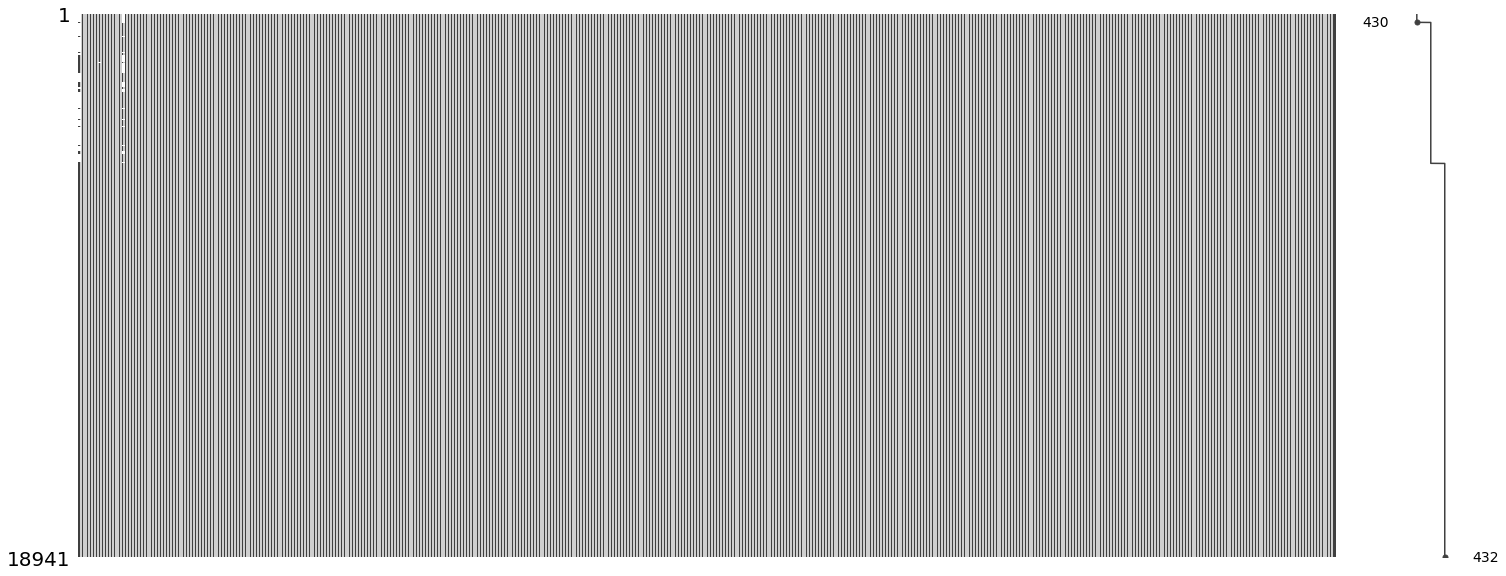

In [9]:
msn.matrix(merged, sort='ascending')

In [8]:
toEncode = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State']

ohe = OneHotEncoder()

temp = ohe.fit_transform(merged[toEncode])
temp = pd.DataFrame(temp.toarray(), index=merged.index)
merged = merged.merge(temp, left_index=True, right_index=True, how='outer')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
train = merged[merged["IsTraining"] == 1]
test = merged[merged["IsTraining"] == 0]

In [11]:
X = train.drop(['SVD_Description0', 'SVD_Description1',
'SVD_Description2', 'SVD_Description3', 'SVD_Description4',
'RescuerID','Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
'Sterilized', 'Health', 'State',"Name", "Description","AdoptionSpeed", "IsTraining"],axis=1).values
y = train["AdoptionSpeed"].values

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

print("Training features size: {}".format(X_train.shape))#
print("Training label size: {}".format(y_train.shape))
print("Testing features size: {}".format(X_test.shape))
print("Testing label size: {}".format(y_test.shape))

(14993, 408)
(14993,)
Training features size: (11994, 408)
Training label size: (11994,)
Testing features size: (2999, 408)
Testing label size: (2999,)


In [ ]:
X.sample()

def run_skfold(clf):
    skf = StratifiedKFold(n_splits=10, random_state=1337)
    outcomes = []
    preds = []
    fold = 0
    for train_index, test_index in skf.split(X,y):
        fold += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        cks = cohen_kappa_score(y_test, predictions)
        outcomes.append(cks)
        preds.append(predictions)
        print("Fold {0} cks: {1}".format(fold, cks))     
    mean_outcome = np.mean(outcomes)
    preds = mean_preds(preds)
    print("Mean cks: {0}".format(mean_outcome)) 
    return mean_outcome, preds

def mean_preds(preds, label_count=5):
    labels = [[],[],[],[],[]]
    norm_counts = [pd.value_counts(i, normalize=True) for i in preds]
    for i in range(len(norm_counts)):
        for j in range(label_count):
            if norm_counts[i][norm_counts[i].index==j].values:
                labels[j].append(norm_counts[i][norm_counts[i].index==j].values)
            else: labels[j].append(0)
            
    mean_preds = [float(mean(i)) for i in labels]
    print(mean_preds)
    return mean_preds

Classifier = pd.DataFrame()

clfs = [DecisionTreeClassifier(),ExtraTreeClassifier(),ExtraTreesClassifier(),
       GaussianNB(),KNeighborsClassifier(),LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),
      LogisticRegression(solver='lbfgs', multi_class = "multinomial"),
        RidgeClassifier(),RandomForestClassifier(), xgb.XGBClassifier(), lgb.LGBMClassifier()]

for clf in clfs:
    print("Fitting model using {}".format(clf))
    start = time.time()
    Classifier_Classifier = str(clf).split('(')[0]
    
    Classifier_Score, Classifier_Preds = run_skfold(clf)

        
    Classifier_Time = time.time()-start    
    Classifier_Values = pd.Series([Classifier_Classifier, Classifier_Score, *Classifier_Preds, Classifier_Time])
    Classifier = Classifier.append(Classifier_Values, ignore_index=True)
    
Classifier.columns=["Classifier", "Cohen_Kappa", "0_pred", "1_pred","2_pred", "3_pred","4_pred", "Time"]

In [ ]:
Classifier

In [ ]:
sns.barplot(Classifier["Classifier"], Classifier["Cohen_Kappa"])
plt.xticks(rotation=90)

In [ ]:
plt.bar(x=range(5),height=Classifier[["0_pred", "1_pred","2_pred", "3_pred","4_pred"]].mean(),alpha=.5,color="red")
plt.bar(x=range(5), height=X_temp["AdoptionSpeed"].value_counts(normalize=True).sort_values(),alpha=.5,color="blue")

params = {
          "num_leaves":[31], 
          "max_depth":[5,10,-1], 
          "learning_rate":[0.001, 0.01, 0.1], 
          "n_estimators":[100],  
          "objective":["multiclass"], 
          "subsample":[0.8,1.0], 
          "colsample_bytree":[0.8,1.0], 
          "reg_alpha":[0.0, 0.25], 
          "reg_lambda":[0.0, 0.25], 
          "random_seed":[1337], 
          "silent":[True]}

LGB = lgb.LGBMClassifier()
clf = GridSearchCV(LGB, params, cv=5)
clf.fit(X,y)

In [ ]:
clf.best_params_

params = {'colsample_bytree': [0.75,0.8,0.95],
'learning_rate': [0.1,0.05,0.15],
 'max_depth': [10,5,15],
 'n_estimators': [100],
 'num_leaves': [28,31,33],
 'objective': ['multiclass'],
 'random_seed': [1337],
 'reg_alpha': [0.15,0.25,0.35],
 'reg_lambda': [0,0.05,0.1],
 'silent': [True],
 'subsample': [0.75,0.8,0.85]}

LGB = lgb.LGBMClassifier()
clf = GridSearchCV(LGB, params, cv=5)
clf.fit(X_train,y_train)

In [ ]:
clf.best_score_

In [12]:
params = {'colsample_bytree': [0.75],
'learning_rate': [0.1],
 'max_depth': [10],
 'n_estimators': [100],
 'num_leaves': [33],
 'objective': ['multiclass'],
 'random_seed': [1337],
 'reg_alpha': [0.25],
 'reg_lambda': [0,0],
 'silent': [True],
 'subsample': [0.8]}

In [13]:
LGB = lgb.LGBMClassifier()
clf = GridSearchCV(LGB, params, cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'colsample_bytree': [0.75], 'learning_rate': [0.1], 'max_depth': [10], 'n_estimators': [100], 'num_leaves': [33], 'objective': ['multiclass'], 'random_seed': [1337], 'reg_alpha': [0.25], 'reg_lambda': [0, 0], 'silent': [True], 'subsample': [0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
clf.best_params_

In [22]:
params = clf.best_params_

print(X.shape)
print(test.shape)

(14993, 408)
(3948, 432)


In [21]:
LGB.fit(X,y)
LGB.predict(test)

ValueError: Number of features of the model must match the input. Model n_features_ is 408 and input n_features is 432 

In [23]:
test.drop(['SVD_Description0', 'SVD_Description1',
'SVD_Description2', 'SVD_Description3', 'SVD_Description4',
'RescuerID','Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
'Sterilized', 'Health', 'State',"Name", "Description","AdoptionSpeed", "IsTraining"],axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
preds = clf.predict(test)

In [30]:
submission = pd.DataFrame([int(i) for i in preds], index=test.index)
submission.columns = ["AdoptionSpeed"]

In [31]:
submission

,AdoptionSpeed
PetID,
378fcc4fc,1
73c10e136,4
72000c4c5,4
e147a4b9f,3
43fbba852,4
77a490ec9,4
28c4b1b13,4
d1eada628,4
d134dec34,4


In [27]:
submission.to_csv("submission.csv")

In [ ]:
import gc
gc.collect()